enter a number for the algorithms: 
1 - for logistic regression
2 - for naive bayes classification
3 - for random forest classifier
2
naive bayes
For noise level 0.00 %: 
                     Predicted Positive        Predicted Negative
Actually Positive     83444                    1865
Actually Negative        24                     110

            Positive       Negative
Num Cases:  85309.000000          134.00
precision:    1.00            0.06
Recall:       0.98            0.82

naive bayes
For noise level 20.00 %: 
                     Predicted Positive        Predicted Negative
Actually Positive     83468                    1824
Actually Negative        26                     125

            Positive       Negative
Num Cases:  85292.000000          151.00
precision:    1.00            0.06
Recall:       0.98            0.83

naive bayes
For noise level 40.00 %: 
                     Predicted Positive        Predicted Negative
Actually Positive     83602                    17

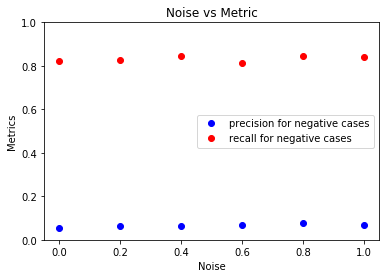

In [36]:

import numpy as np
import pandas as pd
import sklearn.metrics as sklm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import numpy.random as nr
import random
import sklearn.model_selection as ms
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier

#read data
data1 = pd.read_csv('creditcard.csv')

#scale data, last and first column of features is only data unscaled
#print(data.columns)

#take features
Features1 = np.array(data1[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']])

#scale amount column
col = Features1[:, -1]
scaler = preprocessing.StandardScaler().fit(col.reshape(-1,1))
col = scaler.transform(col.reshape(-1,1))
col = np.ravel(col)
Features1[:, -1] = col

#take labels
labels1 = np.array(data1[['Class']])

# Introduce Noise
def intr_noise(Features, labels, frac):
    nr.seed(1234)
    index = range(Features.shape[0])
    #print(Features.shape[0])
    index = random.sample(range(Features.shape[0]), int(frac*float(Features.shape[0]))) 
    noise_data_x = Features[index, :]
    noise_data_y = np.array(labels[index])
    ## get description
    noise_data_x = pd.DataFrame(noise_data_x)
    desc = noise_data_x.describe()
    desc = np.array(desc)
    noise_data_x = np.array(noise_data_x)
    # pick standard dev from description for each column 
    stds = desc[2,:]
    for i in range(len(noise_data_x)):                           #iterate over rows
        for j, std in enumerate(stds):                           #iterate over each column
            w = random.uniform(-std,std)
            noise_data_x[i, j] = noise_data_x[i, j] + w          #add random num from (-std, std) to existing data
    noise_data_y
    data_x = np.vstack((Features, noise_data_x))
    #print(labels.shape, noise_data_y.shape)
    data_y = np.vstack((labels, noise_data_y))
    data_noise = np.column_stack((data_x, data_y))
    data_noise = pd.DataFrame(data_noise)
    #print(data_noise.shape)
    df = shuffle(data_noise)
    df = df.sample(n = 284807)
    #print(df.shape)
    return df

def score_model(y_p, threshold):
    return np.array([1 if x > threshold else 0 for x in y_p[:, 1]])

#apply logistic
def logistic_regression(x_train, x_test, y_train):
    clf=LogisticRegression(fit_intercept=True)
    clf.fit(x_train, y_train)
    y_hat_p = clf.predict_proba(x_test)  #score model based on threshold
    y_hat = score_model(y_hat_p, 0.5)
    return y_hat_p, y_hat

#apply naive bayes
def naive_bayes(x_train, x_test, y_train):
    clf=GaussianNB()
    clf.fit(x_train, y_train)
    y_hat_p = clf.predict_proba(x_test)  #score model based on threshold
    y_hat = score_model(y_hat_p, 0.5)
    return y_hat_p, y_hat

#random forest
def random_forest_classifier(x_train, x_test, y_train):
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)
    y_hat_p = clf.predict_proba(x_test)  #score model based on threshold
    y_hat = score_model(y_hat_p, 0.5)
    return y_hat_p, y_hat

#print metrics
def print_metrics(y_true, y_predicted):
    metrics = sklm.precision_recall_fscore_support(y_true, y_predicted)
    cfmat = sklm.confusion_matrix(y_true, y_predicted)
    print("                     Predicted Positive        Predicted Negative")
    print("Actually Positive    %6d" %cfmat[0][0] + "                  %6d" %cfmat[0][1])
    print("Actually Negative    %6d" %cfmat[1][0] + "                  %6d" %cfmat[1][1])
    print("")
    #print("Accuracy: " + str(sklm.accuracy_score(y_true, y_predicted)))
    #print("")
    print("            Positive       Negative")
    print("Num Cases:  %6f"%metrics[3][0] + "          %6.2f"%metrics[3][1]) 
    print("precision:  %6.2f"%metrics[0][0] + "          %6.2f"%metrics[0][1])
    print("Recall:     %6.2f"%metrics[1][0] + "          %6.2f"%metrics[1][1])
    #print("fscore:     %6.2f"%metrics[2][0] + "          %6.2f"%metrics[2][1])
    print("")
    #mp = (metrics[0][0] + metrics[0][1]) / 2
    #mr = (metrics[1][0] + metrics[1][1]) / 2
    #f1 = (2 * mp * mr) / (mp + mr)
    #ci = float(float(cfmat[1][1])/float(cfmat[1][1] + cfmat[1][0]))
    #print("Correctly identified fraud:  %6.2f"%ci)
    #print("Average Precision:           %6.2f"%mp)
    #print("Average Recall:              %6.2f"%mr)
    #print("F1 Score:                    %6.2f"%f1)
    #cohen_score = cohen_kappa_score(y_true, y_predicted)
    #print("Cohen kappa:                 %6.2f"%cohen_score)
    return metrics[0][1], metrics[1][1]
#[0,0.2,0.3,0.6,0.9]
print("enter a number for the algorithms: ")
print("1 - for logistic regression")
print("2 - for naive bayes classification")
print("3 - for random forest classifier")
choice=int(input())
#print(choice, choice.dtype)
for i, noise in enumerate([0,0.2,0.4,0.6,0.8,1]):
    df = intr_noise(Features1, labels1, noise)
    #print(df.shape, df.columns, df.tail())
    labels = np.array(df[29])
    df = df.drop((29), axis = 1)  #drop Class feature
    Features = np.array(df)
    #split data randomly into test and train

    nr.seed(9988)
    index = range(df.shape[0])
    index = ms.train_test_split(index,test_size=0.3)
    x_train = np.array(Features[index[0], :])
    y_train = np.ravel(labels[index[0]])
    x_test = np.array(Features[index[1], :])
    y_test = np.ravel(labels[index[1]])
    #print (y_test)
    #print (y_train.shape)
    #choice = 1
    if choice == 1:
        print ("logistic regression")
        y_hat_p, y_hat = logistic_regression(x_train, x_test, y_train)
    if choice == 2:
        print("naive bayes")
        y_hat_p, y_hat = naive_bayes(x_train, x_test, y_train)
    if choice == 3:
        print("random forest")
        y_hat_p, y_hat = random_forest_classifier(x_train, x_test, y_train)
    print("For noise level %.2f %%: "%(noise*100))
    p, r = print_metrics(y_test, y_hat)
    if i == 0:
        plt.plot(noise, p, 'bo', label = 'precision for negative cases')
        plt.plot(noise, r, 'ro', label = 'recall for negative cases')
        #plt.plot(noise, f, 'ro', label = 'f1score for negative cases')
    else:
        plt.plot(noise, p, 'bo')
        plt.plot(noise, r, 'ro')
        #plt.plot(noise, f, 'ro')
    
plt.xlabel('Noise')
plt.ylabel('Metrics')
plt.title('Noise vs Metric')
#plt.title('Noise vs Metric for Random Forest classifier')
#plt.title('Noise vs Metric for naive_bayes classifier')
#plt.xlim((0,1))
plt.ylim((0,1))
plt.legend()
plt.show()